# 📥 Datenimport und Grundsortierung

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
from scipy.stats import kruskal
from scipy.stats import f_oneway
from datetime import datetime
from entsoe import EntsoePandasClient
from meteostat import Point, Daily

df = pd.read_csv('../data/kraftwerksdaten_csv.csv', sep=';')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y %H:%M')
df = df[df['Timestamp'] < pd.Timestamp('2024-02-11')]
df.tail()

# Set modern Seaborn style without grid
sns.set_style("white")
palette = sns.color_palette("viridis")
sns.set_palette(palette)

## 🖼️ Gesamt-Zählerstandsverlauf

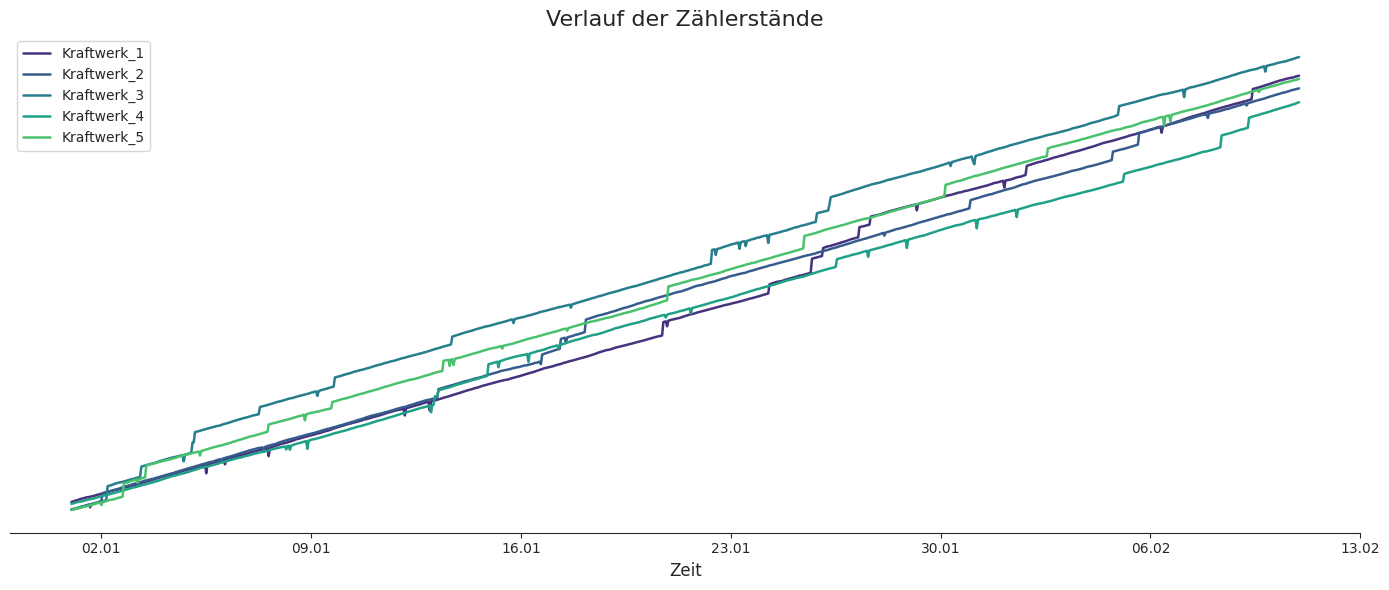

In [190]:
# Plot vorbereiten
plt.figure(figsize=(14, 6))

# Alle Kraftwerke zeichnen
for k, sub in df.groupby('Kraftwerk'):
    plt.plot(sub['Timestamp'], sub['Zaehlerstand'], label=k, linewidth=1.8)

# Gestaltung
plt.title('Verlauf der Zählerstände', fontsize=16)
plt.legend()
# X-Achse
plt.xlabel('Zeit', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
sns.despine()
ax = plt.gca()
# Y-Achse
ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

## 🔍 Zoom: Doppelter Negativ-Spike

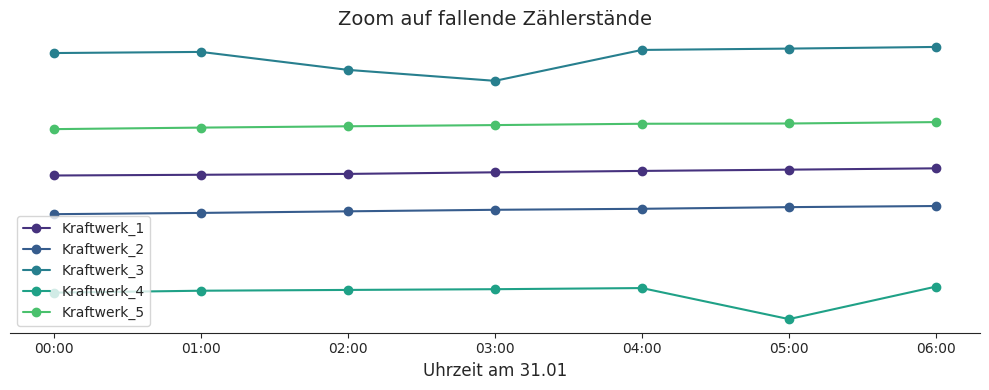

In [191]:
df['neg_jump'] = df.groupby('Kraftwerk')['Zaehlerstand'].diff() < 0
idx = df[df['neg_jump'] & df['neg_jump'].shift(1)].index[0]
t0 = df.loc[idx, 'Timestamp'] - pd.Timedelta(hours=3)
t1 = df.loc[idx, 'Timestamp'] + pd.Timedelta(hours=3)
zoom = df[(df['Timestamp'] >= t0) & (df['Timestamp'] <= t1)]
plt.figure(figsize=(10,4))
for k, sub in zoom.groupby('Kraftwerk'):
    plt.plot(sub['Timestamp'], sub['Zaehlerstand'], marker='o', label=k)
plt.title('Zoom: Doppelter Negativ-Spike im Zählerstand')

# Gestaltung
plt.title('Zoom auf fallende Zählerstände', fontsize=14)
plt.legend()

# X-Achse: Stunde anzeigen
plt.xlabel('Uhrzeit am 31.01', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Y-Achse: optional unsichtbar
ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
ax.spines['left'].set_visible(False)

# Stil
sns.despine(left=True)
plt.legend()
plt.tight_layout()
plt.show()

## Rückläufige Zählerstände – Interpretation & Datenbereinigung

### Beobachtung
- Einzelne Zählerstände sinken plötzlich – einmal über zwei aufeinanderfolgende Stunden
- 55 von 5000 Messungen, entspricht ~1%

### Mögliche Ursachen
- Übertragungsfehler: die aktuellsten Zählerstände aus dem Cache werden zuerst gesendet 
- daher kommen die Messwerte in falscher Reihenfolge an, zB. aus [0, 1, 10, 11] wird [0, 10, 1, 11] (aber hier kündigt kein positiver Sprung den negativer Sprung an)
- Importfehler: einzelne Werte werden nachträglich eingefügt und überschreiben korrekte Messwerte 

### Konsequenz für Analyse
- Rückläufige Zählerstände sind physikalisch nicht plausibel
- Verfälschen abgeleitete Kenngrößen wie Produktionsleistung

→ Datenpunkte mit fallendem Zählerstand werden konsequent entfernt (entfernt sowohl das negative Δ, als auch den darauf folgenden positiven Sprung)

## 🧹 Zählerstandsbereinigung & Berechnung der stündlichen Produktionsleistung

In [192]:
df_clean = df.loc[~df['neg_jump']].copy().reset_index(drop=True)
df_clean['Stundenproduktion'] = df_clean.groupby('Kraftwerk')['Zaehlerstand'].diff()
df_clean = df_clean[df_clean['Stundenproduktion'] > 0]
df_clean.head()

,Timestamp,Kraftwerk,Zaehlerstand,neg_jump,Stundenproduktion
1,2024-01-01 01:00:00,Kraftwerk_1,1695,False,19.0
2,2024-01-01 02:00:00,Kraftwerk_1,1718,False,23.0
3,2024-01-01 03:00:00,Kraftwerk_1,1746,False,28.0
4,2024-01-01 04:00:00,Kraftwerk_1,1765,False,19.0
5,2024-01-01 05:00:00,Kraftwerk_1,1784,False,19.0


## 📈 Histogramm – stündliche Leistung je Kraftwerk

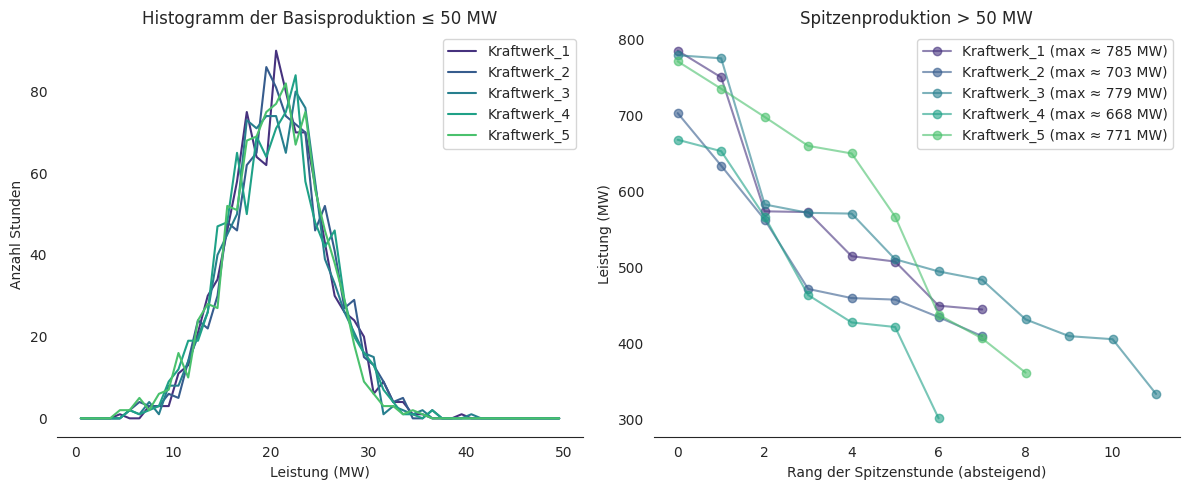

Test H0: die Nicht-Spitzenwerte der Kraftwerke kommen aus der gleichen Verteilung
ANOVA F-statistic = 1.695, p = 0.148
Test H0: die Spitzenwerte der Kraftwerke kommen aus der gleichen Verteilung
Kruskal-Wallis H-statistic = 2.445, p = 0.655


In [202]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
df_plot = df_clean.copy()

# ≤ 50 MW — Histogramm
for k, sub in df_plot.groupby('Kraftwerk'):
    c, b = np.histogram(sub['Stundenproduktion'], bins=np.linspace(0, 50, 51))
    ax1.plot(0.5 * (b[1:] + b[:-1]), c, label=k)
ax1.set_title('Histogramm der Basisproduktion ≤ 50 MW')
ax1.set_xlabel('Leistung (MW)')
ax1.set_ylabel('Anzahl Stunden')
ax1.legend()
sns.despine(ax=ax1)
ax1.spines['left'].set_visible(False)

# > 50 MW — Scatterplot der Peaks
for k, sub in df_plot.groupby('Kraftwerk'):
    hi = sub[sub['Stundenproduktion'] > 50]['Stundenproduktion'].dropna()
    peaks = hi.sort_values(ascending=False).reset_index(drop=True)
    if peaks.empty:
        continue

    x = np.arange(len(peaks))
    y = peaks.values
    max_val = y.max()

    ax2.plot(x, y, marker='o', linestyle='-', alpha=0.6,
             label=f'{k} (max ≈ {max_val:.0f} MW)')

ax2.set_title('Spitzenproduktion > 50 MW')
ax2.set_xlabel('Rang der Spitzenstunde (absteigend)')
ax2.set_ylabel('Leistung (MW)')
sns.despine(ax=ax2)
ax2.spines['left'].set_visible(False)
ax2.legend()

plt.tight_layout()
plt.show()


# Non-Peaks, test if Kraftwerke come from the same distribution
print("Test H0: die Nicht-Spitzenwerte der Kraftwerke kommen aus der gleichen Verteilung")
df_non_peaks = df_plot[df_plot['Stundenproduktion'] < 50]
grouped = [df_non_peaks[df_non_peaks['Kraftwerk'] == k]['Stundenproduktion'].dropna() for k in df_non_peaks['Kraftwerk'].unique()]
stat, p = f_oneway(*grouped)
print(f"ANOVA F-statistic = {stat:.3f}, p = {p:.3g}")

# Peaks, test if Kraftwerke come from the same distribution
print("Test H0: die Spitzenwerte der Kraftwerke kommen aus der gleichen Verteilung")
df_peaks = df_plot[df_plot['Stundenproduktion'] > 50]
grouped = [df_peaks[df_peaks['Kraftwerk'] == k]['Stundenproduktion'].dropna() for k in df_peaks['Kraftwerk'].unique()]
stat, p = kruskal(*grouped)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p = {p:.3g}")

## Hypothese: Gleicher Kraftwerkstyp

Die Verteilungen der Stundenproduktionen zeigen starke Ähnlichkeit – sowohl im Bereich bis 50 MW als bei den 44 Spitzenwerten über 50MW.  
Statistische Tests (ANOVA und Kruskal-Wallis) zeigen keine signifikanten Unterschiede zwischen den Kraftwerken.

**Es ist plausibel, dass es sich bei den fünf Kraftwerken um denselben Kraftwerkstyp handelt.**

## ⚡ Day-Ahead Strompreise von der Entsoe API

In [ ]:
client = EntsoePandasClient(api_key='cac6e8e9-a624-4687-a6dc-ffd3d28194f3')
start = pd.Timestamp('20240101', tz='Europe/Berlin')
end = pd.Timestamp('20240210', tz='Europe/Berlin')
prices = client.query_day_ahead_prices(country_code='DE_LU', start=start, end=end)
price_df = prices.rename_axis('timestamp').reset_index(name='price')
price_df['hour'] = price_df['timestamp'].dt.hour
price_df['day'] = price_df['timestamp'].dt.date
price_df.head()

,timestamp,price,hour,day
0,2024-01-01 00:00:00+01:00,0.10,0,2024-01-01
1,2024-01-01 01:00:00+01:00,0.01,1,2024-01-01
2,2024-01-01 02:00:00+01:00,0.00,2,2024-01-01
3,2024-01-01 03:00:00+01:00,-0.01,3,2024-01-01
4,2024-01-01 04:00:00+01:00,-0.03,4,2024-01-01


## 📊 Overlay: Durchschnittliche Leistung vs. Strompreis pro Stunde

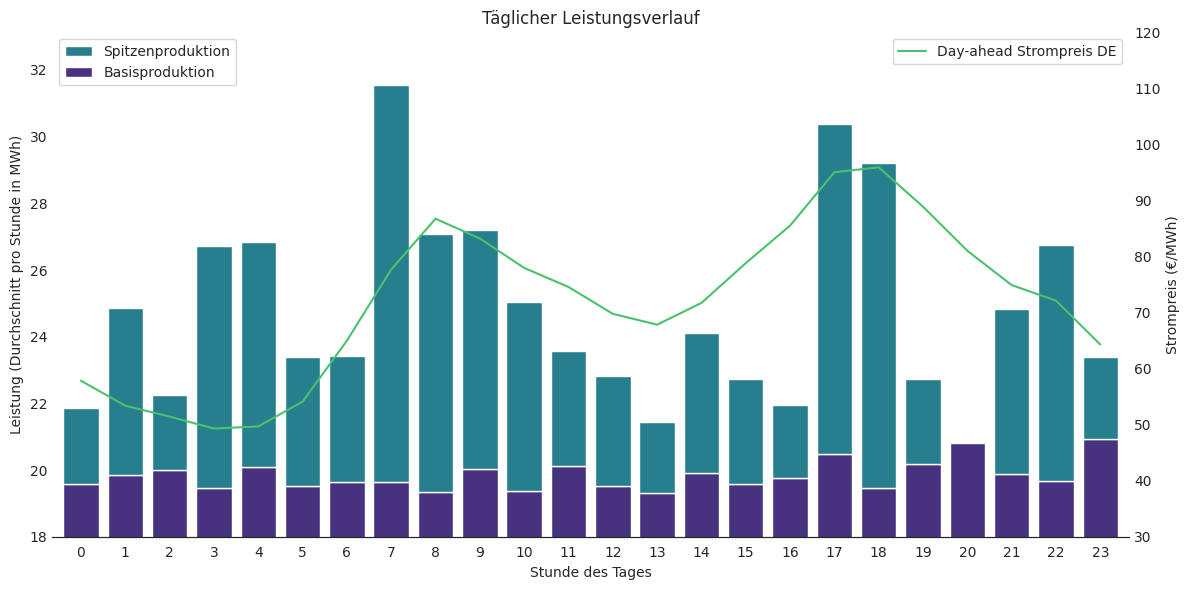

In [185]:
df_clean['Hour'] = df_clean['Timestamp'].dt.hour

# Aufteilen in Basis- und Spitzenproduktion
basis = df_clean[df_clean['Stundenproduktion'] <= 50]
spitze = df_clean[df_clean['Stundenproduktion'] > 50]


# Durchschnittliche stündliche Leistung über alle Tage
n_tage = len(df_clean) / 24
basis_std = basis.groupby('Hour')['Stundenproduktion'].sum() / n_tage
spitze_std = spitze.groupby('Hour')['Stundenproduktion'].sum() / n_tage

# Zusammenführen in ein DataFrame
df_plot = pd.concat([basis_std, spitze_std], axis=1,
                    keys=['Basisproduktion', 'Spitzenproduktion']).fillna(0)
df_plot['Gesamt'] = df_plot.sum(axis=1)
df_plot = df_plot.reset_index()

# Plot vorbereiten
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gestapeltes Balkendiagramm für Leistung
df_plot[['Basisproduktion', 'Spitzenproduktion']].plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color = [palette[0], palette[2]],
    width=0.8
)

# Achsenbeschriftungen und Titel
ax1.set_title("Täglicher Leistungsverlauf")
ax1.set_xlabel("Stunde des Tages")
ax1.set_ylabel("Leistung (Durchschnitt pro Stunde in MWh)")
ax1.set_xticks(range(24))
ax1.set_xticklabels(df_plot['Hour'], rotation=0)
ax1.set_ylim(bottom=18)
ax1.tick_params(axis='y', length=0)

# Strompreis auf sekundärer Achse
ax2 = ax1.twinx()
preis_std = price_df.groupby('hour')['price'].mean()
ax2.plot(preis_std.index, preis_std.values, color = palette[4], label='Day-ahead Strompreis DE')
ax2.set_ylabel("Strompreis (€/MWh)")
ax2.set_ylim(30, 120)
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', length=0)

# Legende für Produktion
handles, labels = ax1.get_legend_handles_labels()
order = [1, 0]  # Spitzenproduktion zuerst
ax1.legend([handles[i] for i in order],
           [labels[i] for i in order], loc='upper left')

sns.despine(ax = ax1)
sns.despine(ax = ax2)
ax1.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


## Interpretation des Leistungsverlaufs innerhalb des Tages

1. **Konstante Basisproduktion**  
   - Violette Balken (≤ 50 MW/h) schwanken kaum → zuverlässige Grundlast.

2. **Zwei deutliche Leistungsspitzen**  
   - Türkise Anteile steigen morgens **07–09 Uhr** und abends **17–18 Uhr**.  
   - Muster entspricht typischen Nachfrage-Hochlasten; spricht gegen Import- oder Messfehler.

3. **Preisabhängigkeit, aber nicht 1:1**  
   - Grüne Strompreiskurve steigt tagsüber an, erreicht Maximum am frühen Abend.  
   - Leistung folgt Preistrend nur teilweise → Fahrweise wohl durch Last und Verträge bestimmt.

## 🌡️ Tagesdurchschnittstemperaturen (2-Tage-Lag) über Meteostat

In [186]:
berlin = Point(52.52, 13.41)
start = datetime(2023, 12, 30)
end = datetime(2024, 2, 10)
weather = Daily(berlin, start, end).fetch().reset_index()
weather['Day'] = weather['time'].dt.date
weather['tavg_lag2'] = weather['tavg'].shift(2)

## 📊 Overlay: Tägliche Produktion vs. Temperatur (2-Tages-Lag)

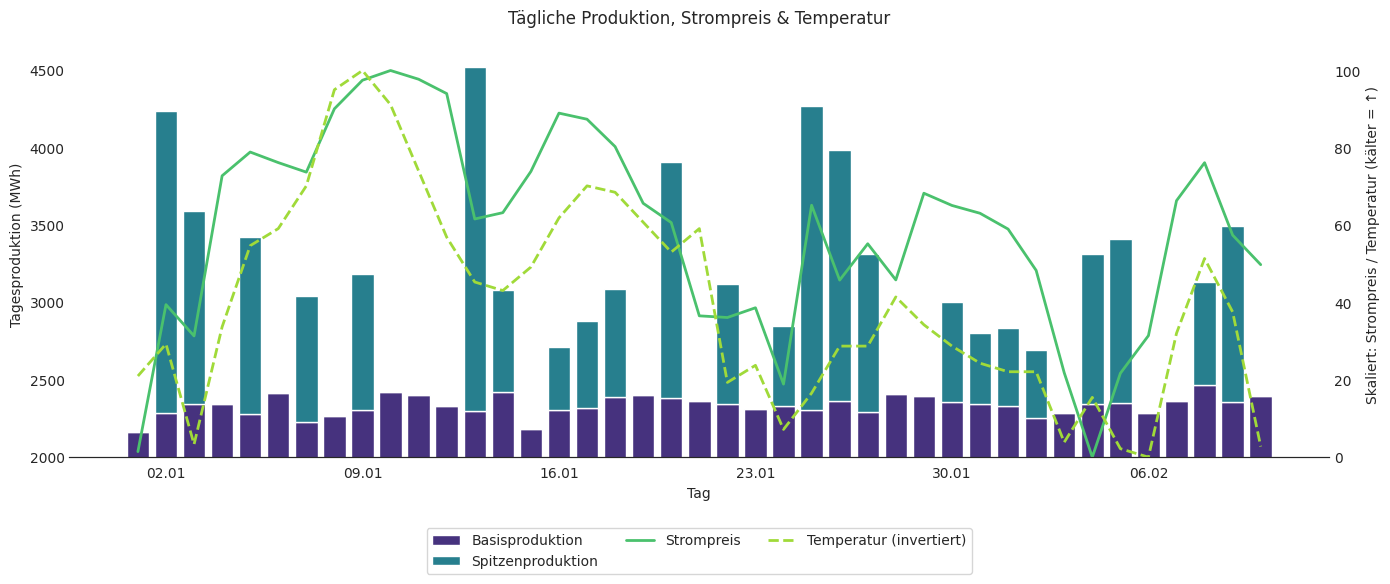

In [ ]:
# Datum extrahieren
df_clean['Day'] = df_clean['Timestamp'].dt.date

# Basis- und Spitzenproduktion pro Tag berechnen
basis = df_clean[df_clean['Stundenproduktion'] <= 50]
spitze = df_clean[df_clean['Stundenproduktion'] > 50]

basis_day = basis.groupby('Day')['Stundenproduktion'].sum()
spitze_day = spitze.groupby('Day')['Stundenproduktion'].sum()

df_prod = pd.concat([basis_day, spitze_day], axis=1,
                    keys=['Basisproduktion', 'Spitzenproduktion']).fillna(0).reset_index()

# Strompreise aggregieren
price_df['Day'] = price_df['timestamp'].dt.date
preis_day = price_df.groupby('Day')['price'].mean().reset_index(name='Strompreis')

# Temperaturdaten vorausgesetzt im Format: weather['Day'], weather['tavg_lag2']
# Alle drei Tabellen mergen
merged = df_prod.merge(preis_day, on='Day').merge(weather, on='Day')


# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Gestapelte Balken: Tagesproduktion
ax1.bar(merged['Day'], merged['Basisproduktion'], label='Basisproduktion', color=palette[0])
ax1.bar(merged['Day'], merged['Spitzenproduktion'],
        bottom=merged['Basisproduktion'], label='Spitzenproduktion', color=palette[2])
ax1.set_ylabel('Tagesproduktion (MWh)')
ax1.set_xlabel('Tag')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax1.set_ylim(bottom=2000)
ax1.set_title('Tägliche Produktion, Strompreis & Temperatur')

# Skalieren der Temperatur und Strompreis auf denselben Bereich (z. B. 0–100)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))
scaled = scaler.fit_transform(merged[['Strompreis', 'tavg']])

# Skaliert + Temperatur invertiert
merged['Strompreis_scaled'] = scaled[:, 0]
merged['Temperatur_scaled'] = 100 - scaled[:, 1]

# Rechte Achse mit skalierten Werten
ax2 = ax1.twinx()
ax2.plot(merged['Day'], merged['Strompreis_scaled'], color=palette[4], label='Strompreis', linewidth=2)
ax2.plot(merged['Day'], merged['Temperatur_scaled'], color=palette[5], linestyle='--', label='Temperatur (invertiert)', linewidth=2)
ax2.set_ylabel('Skaliert: Strompreis / Temperatur (kälter = ↑)')
ax2.set_ylim(0, 110)

# Kombinierte Legende
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

sns.despine(ax = ax1)
sns.despine(ax = ax2)
ax1.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(axis='y', length=0)
ax2.tick_params(axis='y', length=0)

plt.tight_layout()
plt.show()

## Fazit: Fahrweise der Anlage

- Keine signifikante Korrelation mit Strompreisen oder Außentemperatur

- Wahrscheinliche Betriebsweise:

  1. Wärmegeführtes BHKW  
     - mit Wärmespeicher oder  
     - festen Fernwärmelast-Verträgen

  2. Regelenergiegeführte Anlage  
     - Aktivierung nach Netzbedarf, nicht Marktpreis

- Keine Hinweise auf Peak-Load-Anlage mit Spotmarktoptimierung

## Methodik & Beobachtungen

**Tools:**
- Python (pandas, scipy, matplotlib, seaborn)
- Jupyter Notebook zur reproduzierbaren Analyse
- API‑Zugriffe für Strompreis- und Wetterdaten

**Methodik:**
- Anomalieerkennung rückläufiger Zählerstände
- Histogramme & Load-Duration-Curves
- Zeitliche Profile (Stunde, Tagesverlauf)
- Statistische Tests (ANOVA, Kruskal-Wallis)

**Muster:**
- Basislast aller Kraftwerke konstant bei ca. 20 MW
- Wiederkehrende Spitzen 07–09 Uhr & 17–18 Uhr
- Keine klare Kopplung an Strompreis oder Außentemperatur

**Potenzielle Probleme:**
- Rücksprünge in Zählerständen in ca. 1 % der Datenpunkte